In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import os

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.case_studies.tohoku.resources.gauges.sample import *

# Gauge data for Tohoku tsunami

We have two different types of gauge: GPS gauges and pressure gauges.
In the former case, the observed variable is free surface displacement.
In the latter case, the observed variable is pressure.

We deduce free surface elevation from pressure using hydrostatic assumptions:

$$p_{\mathrm{hydrostatic}}=\rho gh,$$

where $\rho\approx1030.0\,\mathrm{kg\,m}^{-3}$ is the density of sea water, $g\approx9.81\,\mathrm{m\,s}^{-2}$ is gravitational acceleration and $H$ is the height of the fluid column.

The height of the fluid column may be decomposed as

$$H=b + \eta,$$

where the bathymetry $b$ $[\mathrm m]$ is known and $\eta$ is the free surface displacement we seek.

_[These calculations are performed using_ `preproc.py`, _which outputs the_ `.dat` _files.]_

## The data

First let's take a look at what the data looks like once it has been converted into appropriate units.

In [26]:
op = TohokuOptions()

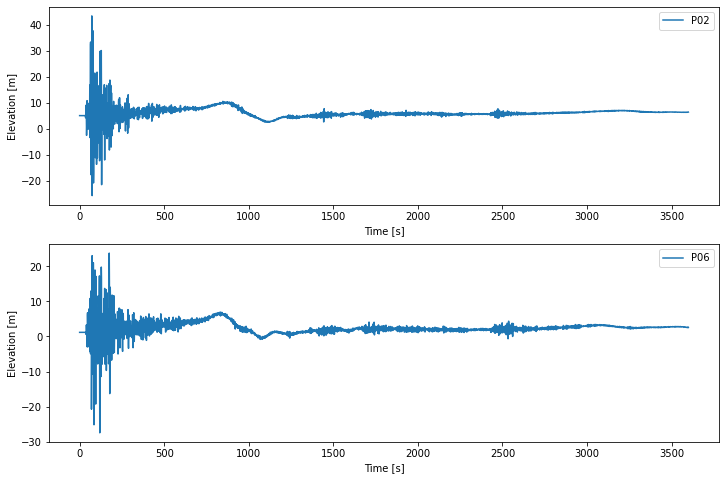

In [40]:
gauges = op.near_field_pressure_gauges["gauges"]
n = len(gauges)
fig, axes = plt.subplots(nrows=n, figsize=(12, n*4))

for i, gauge in enumerate(gauges):
    axes[i].plot(*get_raw_data(gauge), label=gauge)
    axes[i].set_xlabel("Time [s]")
    axes[i].set_ylabel("Elevation [m]")
    axes[i].legend()

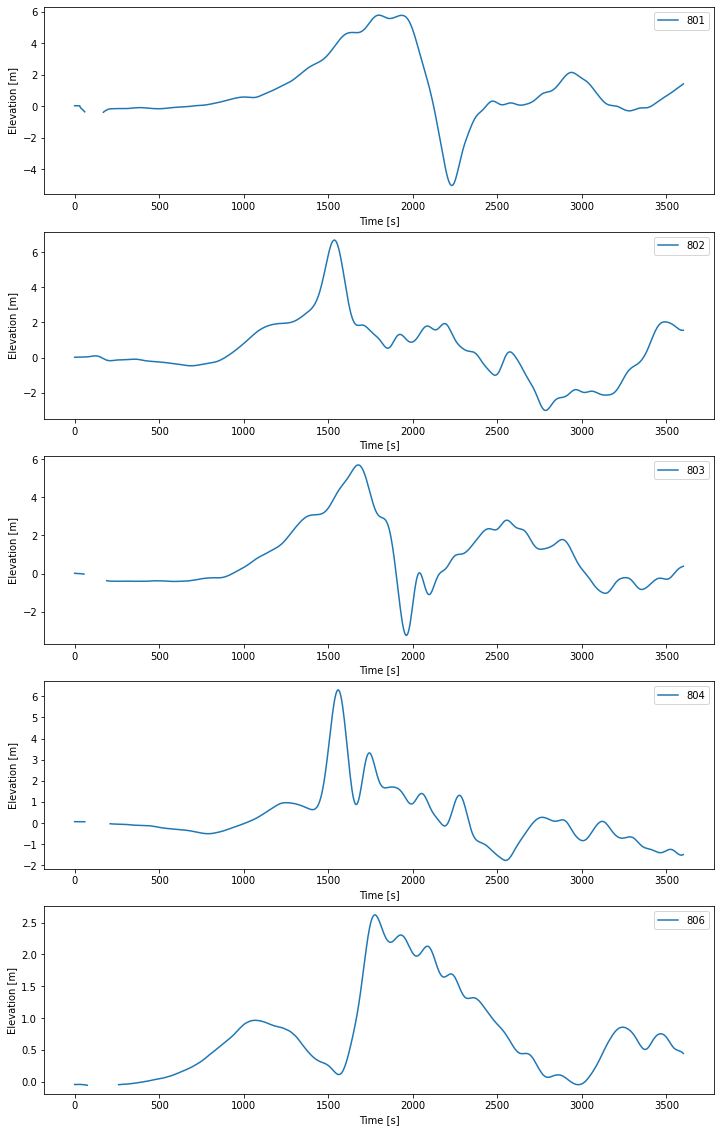

In [41]:
gauges = op.near_field_gps_gauges["gauges"][:5]  # TODO: consider 807
n = len(gauges)
fig, axes = plt.subplots(nrows=n, figsize=(12, n*4))

for i, gauge in enumerate(gauges):
    axes[i].plot(*get_raw_data(gauge), label=gauge)
    axes[i].set_xlabel("Time [s]")
    axes[i].set_ylabel("Elevation [m]")
    axes[i].legend()

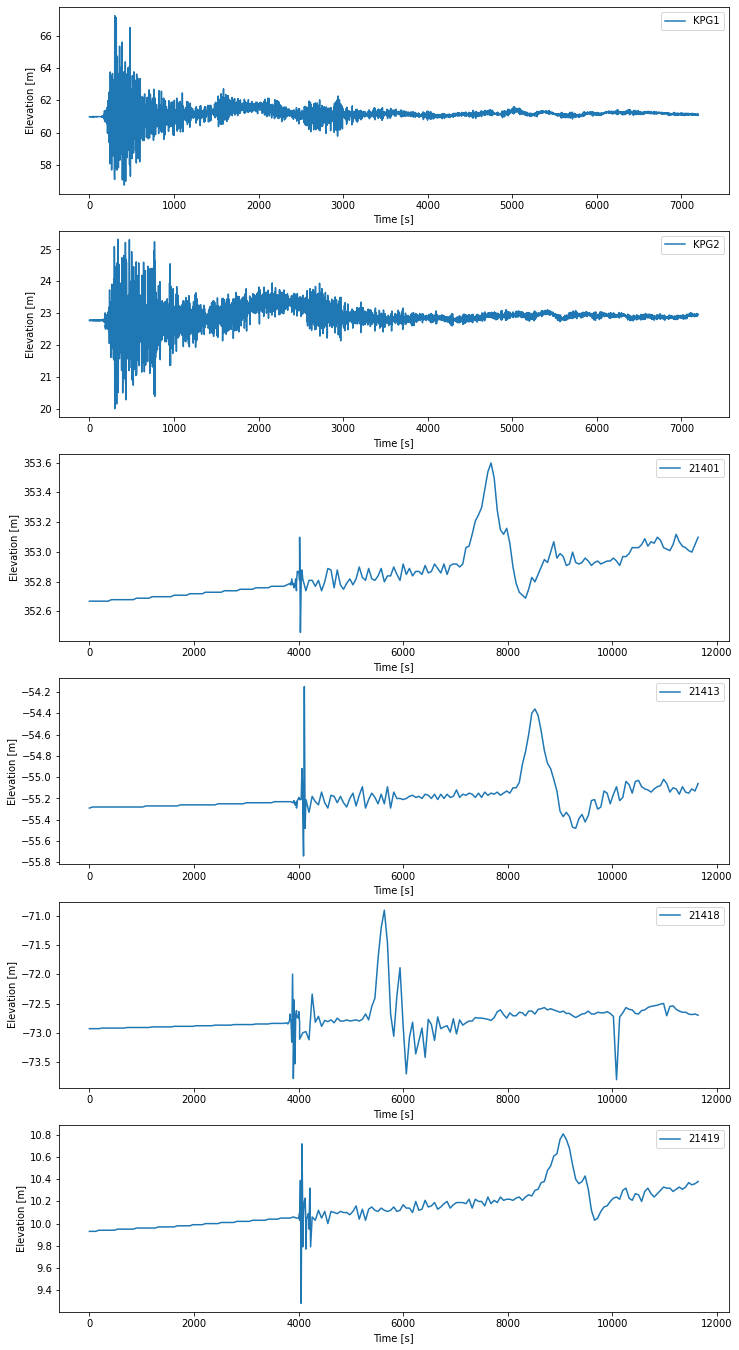

In [42]:
gauges = op.far_field_pressure_gauges["gauges"]
n = len(gauges)
fig, axes = plt.subplots(nrows=n, figsize=(12, n*4))

for i, gauge in enumerate(gauges):
    axes[i].plot(*get_raw_data(gauge), label=gauge)
    axes[i].set_xlabel("Time [s]")
    axes[i].set_ylabel("Elevation [m]")
    axes[i].legend()

# [TODO: far field GPS gauges]

## GPS gauges

First consider the data from GPS gauges, each of which is located close to the east coast of Japan.

These data are the cleanest, with only a short sequence of observation errors shortly after the earthquake.
These data were provided by the Japanese Port and Airport Research Institute (PARI).

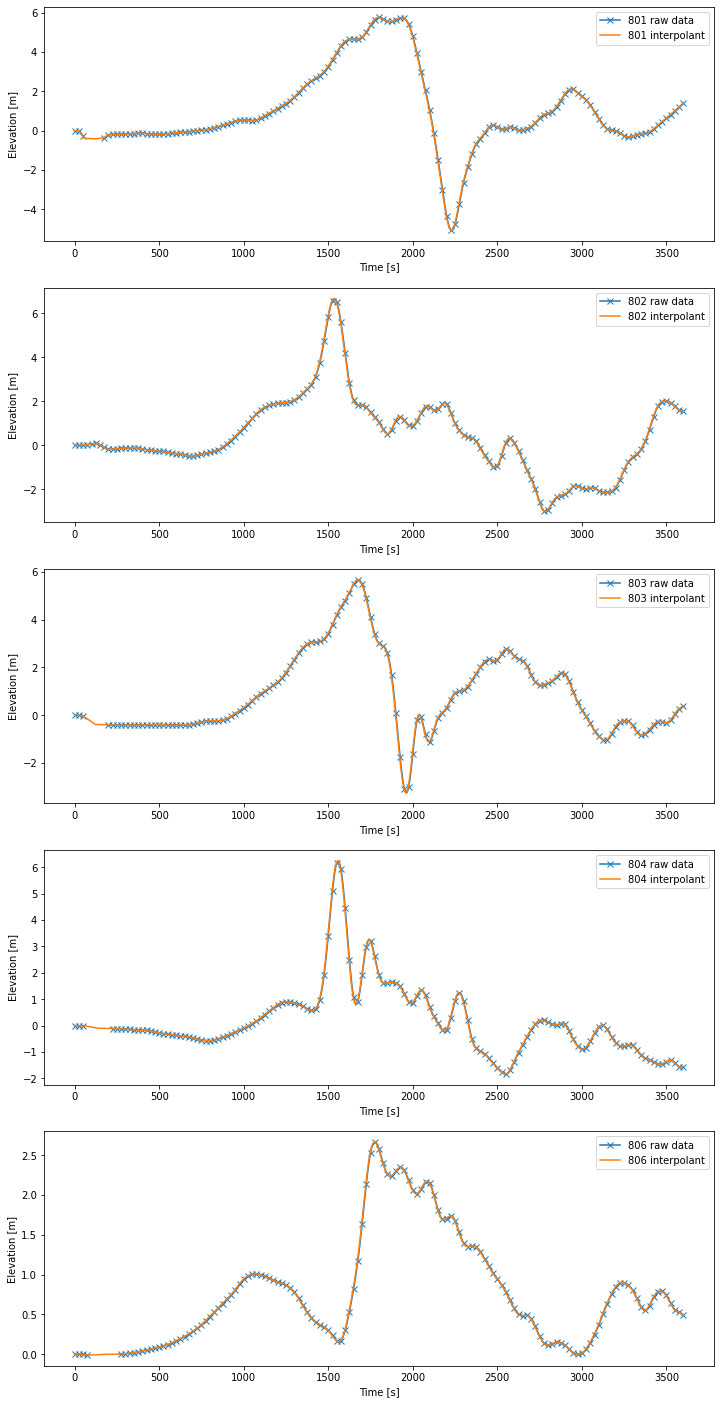

In [5]:
fig, axes = plt.subplots(nrows=len(gps_gauges), figsize=(12, 5*len(gps_gauges)))

times = np.linspace(0.0, 3600.0, 3601)
for i, gauge in enumerate(gps_gauges):
    ax = axes[i]
    
    gauge_dict[gauge]['interpolator'], raw = sampled_timeseries(gauge)
    gauge_dict[gauge]['data'] = []
    for t in times:
        gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
    raw['values'] = np.array(raw['values']) - raw['values'][0]
    ax.plot(raw['times'], raw['values'], label=gauge.upper() + ' raw data', marker='x', markevery=5)
    ax.plot(times, gauge_dict[gauge]['data'], label=gauge.upper() + ' interpolant')
    ax.set_xlabel("Time [s]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

No sampling is required for the GPS gauges.


## Near field pressure gauges

Next consider the temporary pressure gauges P02 and P06 which were operated by Tohoku University.
These gauges were within the tsunami source region and hence registered a significant signal.

From a previous project we also have free surface elevation data extracted from the figure in [Saito et al. 2011] using `PlotDigitizer`.

In [6]:
plot_digitizer = {}
plot_digitizer["P02"] = [
    0.00, 0.07, 0.12, 0.46, 0.85, 1.20, 1.55, 1.90, 2.25, 2.50, 2.80, 3.10, 3.90, 4.80,
    4.46, 2.25, -0.45, -0.17, -1.60, -0.82, -0.44, -0.26, -0.08, 0.13, 0.42, 0.71
]
plot_digitizer["P06"] = [
    0.00, 0.10, 0.30, 0.65, 1.05, 1.35, 1.65, 1.95, 2.25, 2.55, 2.90, 3.50, 4.50, 4.85,
    3.90, 1.55, -0.35, -1.05, -0.65, -0.30, -0.15, 0.05, 0.18, 0.35, 0.53, 0.74
]

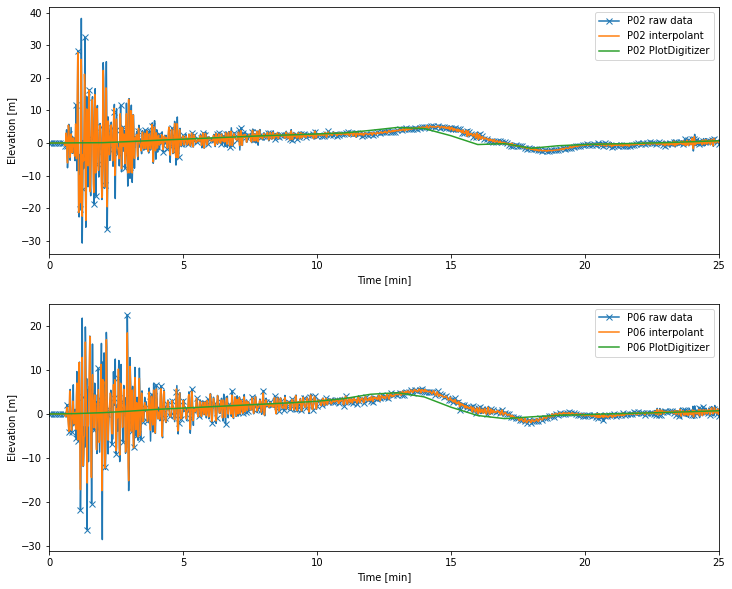

In [7]:
gauges = ("P02", "P06")

fig, axes = plt.subplots(nrows=len(gauges), figsize=(12, 5*len(gauges)))
for i, gauge in enumerate(gauges):
    ax = axes[i]
    
    gauge_dict[gauge]['data'] = []
    gauge_dict[gauge]['interpolator'], raw = sampled_timeseries(gauge, sample=1)
    for t in times:
        gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
    N = len(plot_digitizer[gauge])
    elev = np.array(gauge_dict[gauge]['data'])
    elev -= elev[1]
    elev[0] = 0
    raw['times'] = np.array(raw['times'])/60
    raw['values'] = np.array(raw['values']) - raw['values'][0]
    ax.plot(raw['times'], raw['values'], label=gauge.upper() + ' raw data', marker='x', markevery=5)
    ax.plot(times/60, elev, label=gauge.title() + ' interpolant')
    ax.plot(range(N), plot_digitizer[gauge], label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    if N >= 1:
        ax.set_xlim([0, N-1])
    ax.legend();
plt.savefig("pressure_gauges_raw.png")

We see that there is a lot of noise in this data, likely due to the earthquake which just struck nearby!
It also looks like the raw data and `PlotDigitizer` are out of date.

Let's try sampling over windows and taking the average for a few different sample sizes and shift the `PlotDigitizer` profile by one minute.

It looks like the observations and the `PlotDigitizer` data are about one minute out of sync:

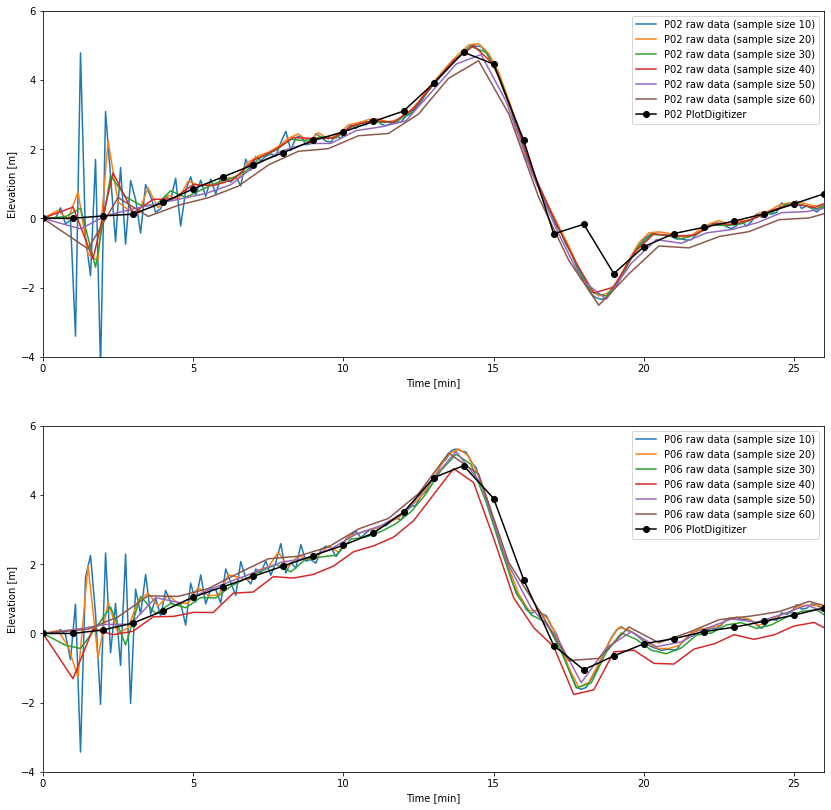

In [8]:
fig, axes = plt.subplots(nrows=len(gauges), figsize=(14, 7*len(gauges)))
for i, gauge in enumerate(gauges):
    ax = axes[i]
    plot_digitizer_ = [0.0, ]  # Push back a minute
    plot_digitizer_.extend(plot_digitizer[gauge])
    N = len(plot_digitizer_)
    for sample in range(10, 70, 10):
        
        gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge, sample=sample)[0]
        gauge_dict[gauge]['data'] = []
        for t in times:
            gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
        elev = np.array(gauge_dict[gauge]['data'])
        elev = np.array([eta for eta, time in zip(elev, times)])
        elev -= elev[0]  # make them all start from zero
        ax.plot(times/60, elev, label='{:s} raw data (sample size {:d})'.format(gauge.title(), sample))
    ax.plot(range(N), plot_digitizer_, marker='o', color='k', label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.set_xlim([0, N-1])
    ax.set_ylim([-4, 6])
    ax.legend();

It seems averaging the data over every minute interval is sufficient to reduce the noise to an acceptable level, whilst maintaining the general shape of the profile.


# Northerly pressure gauges

Next consider two gauges to the north of the tsunami source, operated by the Japanese Agency for Marine-Earth Science and Technology (JAMSTEC). 

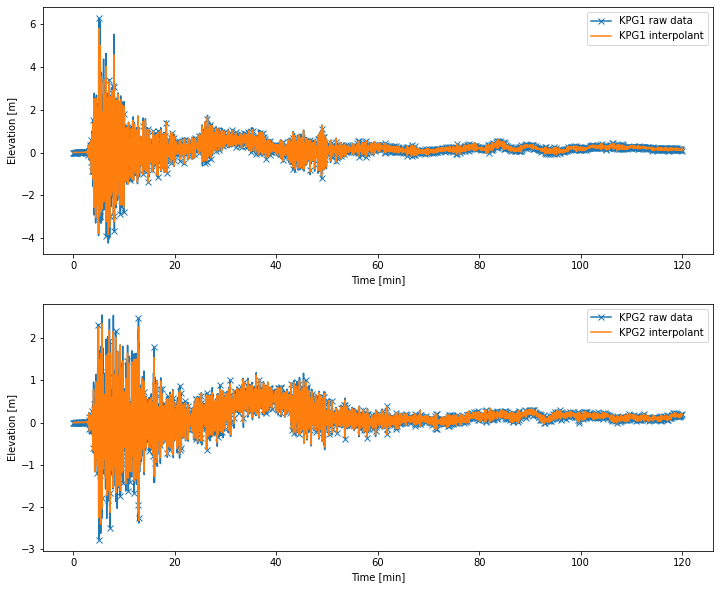

In [9]:
gauges = ("KPG1", "KPG2")
times = np.linspace(0.0, 7200.0, 7201)
fig, axes = plt.subplots(nrows=len(gauges), figsize=(12, 5*len(gauges)))
        
for i, gauge in enumerate(gauges):
    ax = axes[i]
    
    gauge_dict[gauge]['data'] = []
    gauge_dict[gauge]['interpolator'], raw = sampled_timeseries(gauge)
    for t in times:
        gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))

    raw['times'] = np.array(raw['times'])/60
    raw['values'] = np.array(raw['values']) - raw['values'][0]
    ax.plot(raw['times'], raw['values'], label=gauge.upper() + ' raw data', marker='x', markevery=5)
    ax.plot(times/60, gauge_dict[gauge]['data'], label='{:s} interpolant'.format(gauge.upper(), sample))
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

These timeseries are particularly noisy.
Let's see if averaging helps.

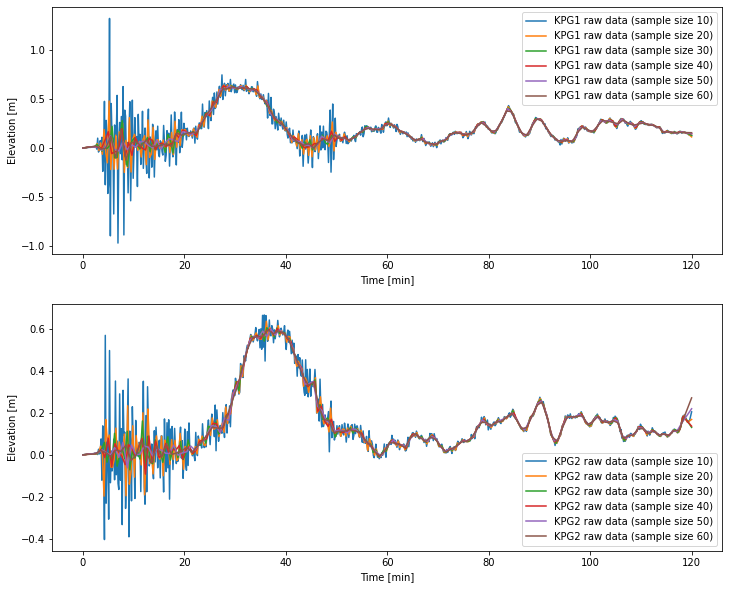

In [10]:
gauges = ("KPG1", "KPG2")
times = np.linspace(0.0, 7200.0, 7201)
fig, axes = plt.subplots(nrows=len(gauges), figsize=(12, 5*len(gauges)))
        
for i, gauge in enumerate(gauges):
    ax = axes[i]
    
    for sample in range(10, 70, 10):
        gauge_dict[gauge]['data'] = []
        gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge, sample=sample)[0]
        for t in times:
            gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
        
        ax.plot(times/60, gauge_dict[gauge]['data'], label='{:s} raw data (sample size {:d})'.format(gauge.upper(), sample))
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

# [FIXME]


## Far field pressure gauges

Finally, there are four DART pressure gauges out in the Pacific which are operated by the US National Oceanic and Atmospheric Administration (NOAA).

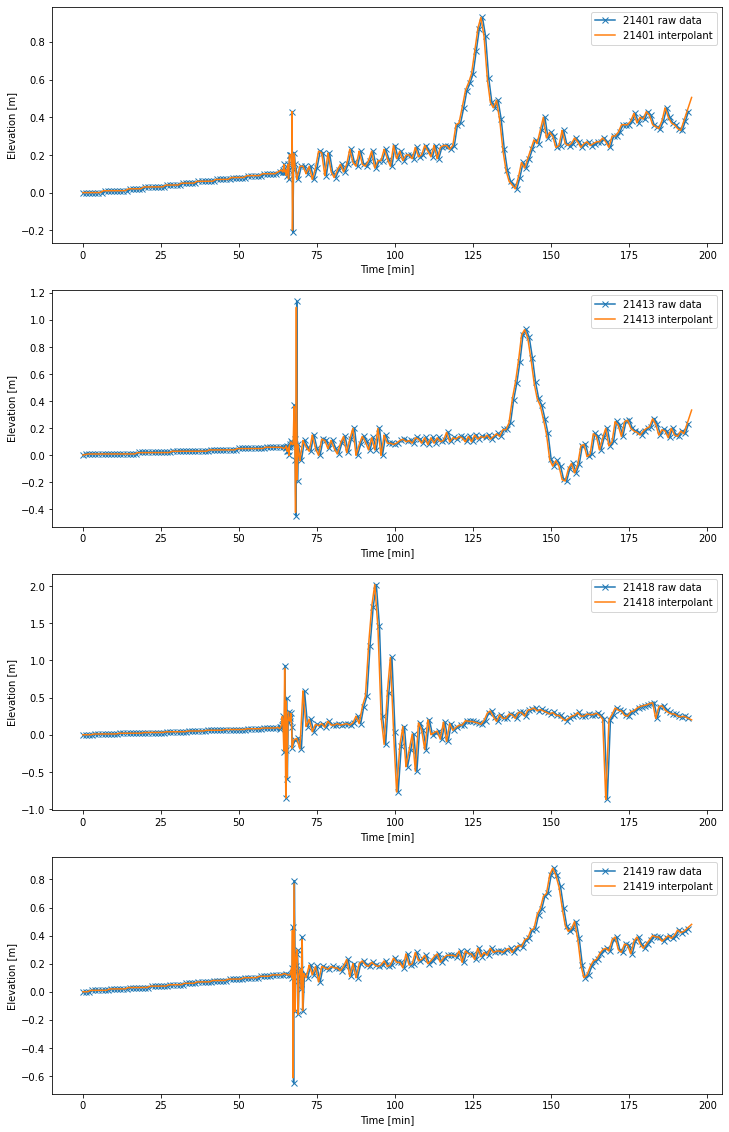

In [13]:
gauges = ('21401', '21413', '21418', '21419')
times = np.linspace(0.0, 3.25*3600.0, 3*3600 + 900 +1)
fig, axes = plt.subplots(nrows=len(gauges), figsize=(12, 5*len(gauges)))

for i, gauge in enumerate(gauges):
    gauge_dict[gauge]['data'] = []
    gauge_dict[gauge]['interpolator'], raw = sampled_timeseries(gauge)
    for t in times:
        gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
    ax = axes[i]
    raw['times'] = np.array(raw['times'])/60
    raw['values'] = np.array(raw['values']) - raw['values'][0]
    ax.plot(raw['times'], raw['values'], label=gauge.upper() + ' raw data', marker='x', markevery=1)
    ax.plot(times/60, gauge_dict[gauge]['data'], label=gauge.upper() + ' interpolant')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

These timeseries make it particularly easy to make out the two waves due to the tsunami: an initial acoustic wave which reaches the DART gauges after around an hour and the gravity wave which reaches later.